# The Eyes have it!
---------------------------

## Introduction

This Jupyterlab note book is an example of using the fastai library to process an image, and return some list of (X,Y) coordinates of interest.

The fastai Machine Learning course I can strongly recommend: [fastai course, version 3](https://course.fast.ai).  The good people at the Coding from Beach Meetup [Coding from Beach](https://www.meetup.com/en-AU/Coding-from-Beach/) organized a set of workshops, for interested people to work through the video lectures as a group.

I was initially very skeptical about the approach, as it involved a top-down approach: hacking out a Python app using the full power of the libraries with not much explanation (other than "trust me, this will work"), and with some dubious Python practices.  However, I now understand the thinking behind this method: motivate the punters by showing how to very easily knock up some very powerful apps, and then come back and explain the theory.  It worked for me (even though I am a bottom up person).

The apps that intrigued me were the ones that took an image and variously:

1. categorised the image into one of a small number of categories (e.g. Picture of a Cat, *or* Picture of a Dog)

2. categorised the image to give a list of categories relevant to that image (e.g. for satellite images - Contains A Road *and* Contains Farmland)

3. categorised each pixel of the image according to some predefined categories (e.g. Road Pixel *or* Tree Pixel *or* Building Pixel)

4. processed an image to return a list of coordinates of the features of interest in that image.  I will use this latter task in this example.

Of course, each of these tasks requires some human to have created a learning database that we can use to train a neural network.

I initially knocked up an app that recognizes Australian urban birds, but that is the subject for another blog post.

## Implementation

I elected to use [Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb) as my development platform, mainly because:

* They have all the correct Python Packages installed
* They allow access to reasonable compute power (using GPUs)
* It's free!  I'm already part of the Google ecosystem, so I had an account already.

I also used [Google Drive](https://www.google.com/drive/) to store the files that you need for training



## Data Source

As an exercise, I decided that I wanted to be able to locate the eyes in a grayscale image. Thankfully, a research group has created a database of images of faces, where the eye positions have been measured, and included as meta-data for each image.  This is [BioID Face Database](https://www.bioid.com/facedb)

## Annotated App Source Code

### Magic commands and imports

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *

--------------
### Access Google Drive Face Database

I have previously upload the marked up face database to Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = Path('/content/gdrive/My Drive/FaceDatabase/BioID-FaceDatabase-V1.2')

### Count images

I was initially uncertain whether this was enough images to train my model, but in the end it was fine.  My bird recogniser app used about 200 color images of birds in each category (species).

In [ ]:
len( list(path.glob('*.jpg')))

1521

### Supporting function to get image meta-data
The face database has text file (with the extension ```.eye```) for each face image.  We use a supporting function to get the path to this meta-data file, given the path to the image.

In [ ]:
#  list the first image path
list(path.glob('*.jpg'))[1]

PosixPath('/content/gdrive/My Drive/FaceDatabase/BioID-FaceDatabase-V1.2/BioID_1022.jpg')

In [ ]:
def imgpath2txtpath(img_path):
  '''
  imagpath2txtpath: converts a image Path object into a corresponding path to a file holding text eye coordinates
  
  Parameters:
  img_path - Path object for image file in BioID-FaceDatabase-V1.2
  
  Returns:
  Path object for corresponding eye coordinate file
  
  Limitations:
  No validation is done that the Path object file exists, or is a BioID image file
  '''
  txt_path = img_path.parent/(img_path.stem+'.eye')
  
  return txt_path
  
 #end imgpath2textpath

Test the supporting function: get an image path, and then get the text meta-data file path.

In [ ]:
zz = path.ls()[1]

In [ ]:
imgpath2txtpath(zz)

PosixPath('/content/gdrive/My Drive/FaceDatabase/BioID-FaceDatabase-V1.2/BioID_1020.eye')

Read the eye positions from the meta-data file, and display them.

In [ ]:
zz_eye = np.genfromtxt( imgpath2txtpath(zz))
zz_eye

array([245., 153., 157., 147.])

Show our image we are using as an example.

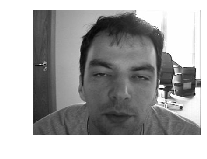

In [ ]:
img = open_image(zz)
img.show()

Define a function to get the coordinates of one eye as a Pytorch / fastai Tensor.

In [ ]:
def get_ctr(imagepath):
  '''
  get_ctr:  returns the center of the left eye for the image at imagepath
  
  Parameters:
  imagepath: Path object pointing to image file; must have corresponding .eye file
  
  returns
  Tensor(y, x)
  '''
  
  txtpath = imgpath2txtpath(imagepath)
  xy_eyes = np.genfromtxt(txtpath)
  
  # NOTE: fastai convention is to have y,x coords (ie row, col)
  
  return tensor([xy_eyes[1], xy_eyes[0] ])
#end get_ctr
  

In [ ]:
get_ctr(zz)

tensor([153., 245.])

Define a function to convert (Row, Column) coordinates into the data structures that fastai ueses to annotate images.

In [ ]:
def get_ip(img,pts): 
  return ImagePoints(FlowField(img.size, pts), scale=True)
#end get_ip

In [ ]:
ctr = get_ctr(zz)

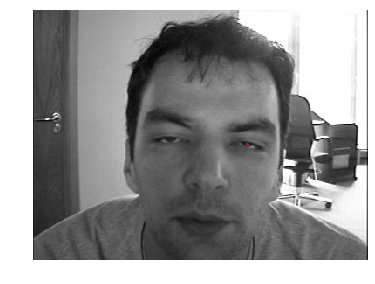

In [ ]:
img.show(y=get_ip(img, ctr), figsize=(6,6))

--------------------------
### Model Eye Pairs

Now are we confident we can get an eye position, we define a function to get both eyes.

In [ ]:
def get_eyes(imagepath):
  '''
  get_eyes:  returns the center of the eyes for the image at imagepath
  
  Parameters:
  imagepath: Path object pointing to image file; must have corresponding .eye file
  
  returns
  Tensor(y1, x1, y2, x2)
  '''
  
  txtpath = imgpath2txtpath(imagepath)
  xy_eyes = np.genfromtxt(txtpath)
  
  # NOTE: fastai convention is to have y,x coords (ie row, col)
  
  return tensor([ [xy_eyes[1], xy_eyes[0]], 
                  [xy_eyes[3], xy_eyes[2]] ])
#end get_eyes

In [ ]:
eyes = get_eyes(zz)

Show bare image.

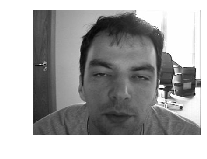

In [ ]:
img.show()

Now show image with eye positions marked.

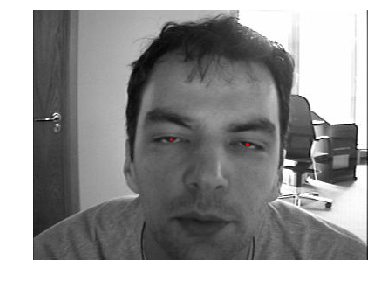

In [ ]:
img.show(y=get_ip(img, eyes), figsize=(6,6))

-------------
## Construct model

The first step in constructing a model is to tell fastai:

1. that we are building a Points From Image model  (so we need a PointsItemList instance)
2. the training images are in a folder at the ```path``` location
3. we hold back 20% of our training images for validation
4. we want ```42``` to be our random number seed
4. we a function ```get_eyes``` to get used to get the points for each image
5. we want the standard transforms, and even if the image warping / transform moves an eye position out of the image area, we still train on this image
6. we use the Imagenet statistics to normalise our images

Imagenet is the source of the pre-trained neural network we will be using.


In [ ]:
path = Path('/content/gdrive/My Drive/FaceDatabase/BioID-FaceDatabase-V1.2')

#  Note that image warping sometime moves eye out of frame; if we have remove_out=True(default)
#  then we get a wrong size Tensor error 

data2 = (PointsItemList.from_folder(path)
        .split_by_rand_pct(valid_pct=0.2, seed=42)
        .label_from_func(get_eyes)
        .transform(get_transforms(), tfm_y=True, size=(120,160), remove_out=False)
        .databunch().normalize(imagenet_stats)
       )

Show a sample of images with eyes marked.

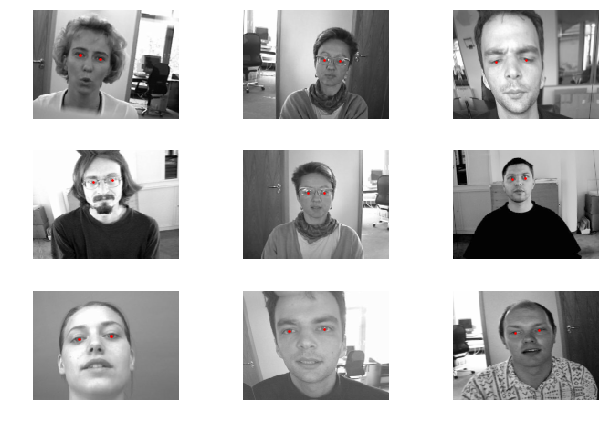

In [ ]:
data2.show_batch(3, figsize=(9,6))

### Train Model

```resnet34``` is a predefined NN architecture.  Look [here](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) for more details.

In [ ]:
learn2 = cnn_learner(data2, models.resnet34)

We then determine a 'good' learning rate.

In [ ]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


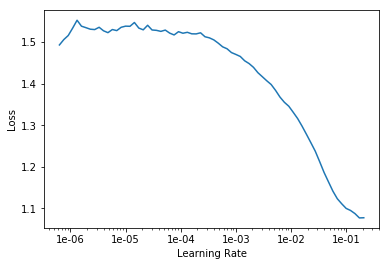

In [ ]:
learn2.recorder.plot()

We choose ```2E-2```, as being a good-enough learning rate (where the slope is greatest).

In [ ]:
learning_rate2 = 2e-2

Now train the model for 5 epochs, and save the result.

In [ ]:
learn2.fit_one_cycle(5, slice(learning_rate2) )

epoch,train_loss,valid_loss,time
0,1.067195,0.754678,00:12
1,0.551069,0.131684,00:13
2,0.326549,0.032579,00:13
3,0.211868,0.022918,00:13
4,0.146619,0.021823,00:13


In [ ]:
learn2.save('/content/gdrive/My Drive/FaceDatabase/face2-stage1')

Let's see how good (or bad) our model is (spoiler: not very good at all).

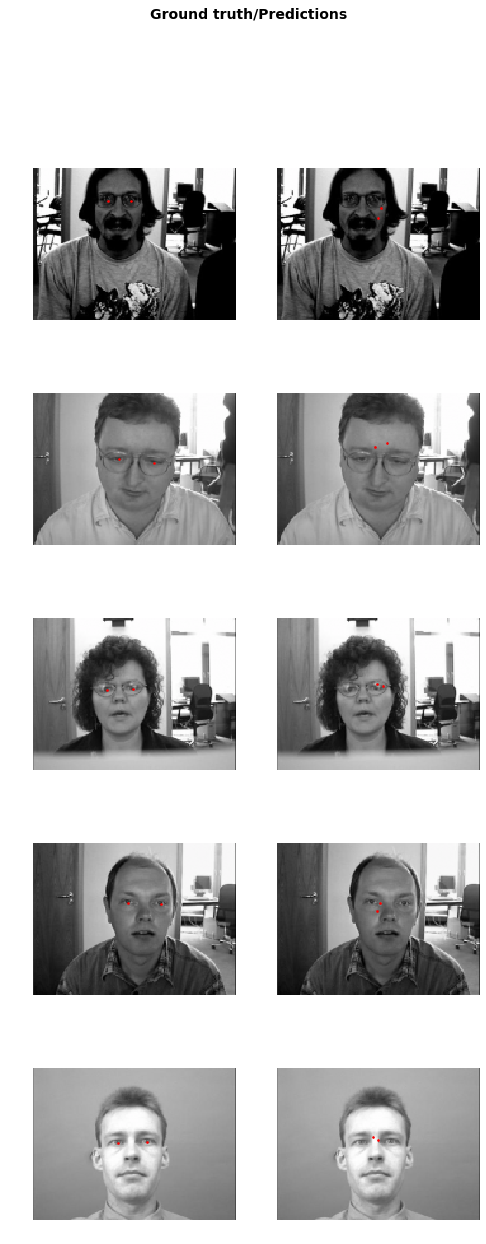

In [ ]:
learn2.show_results()

We now declare that we want all the layers in the NN trained, not just the last few layers.

In [ ]:
learn2.unfreeze()

Train a bit more, ...

In [ ]:
learn2.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.025808,0.013060,00:13


... and the results subjectively (and training loss wise) are getting better.

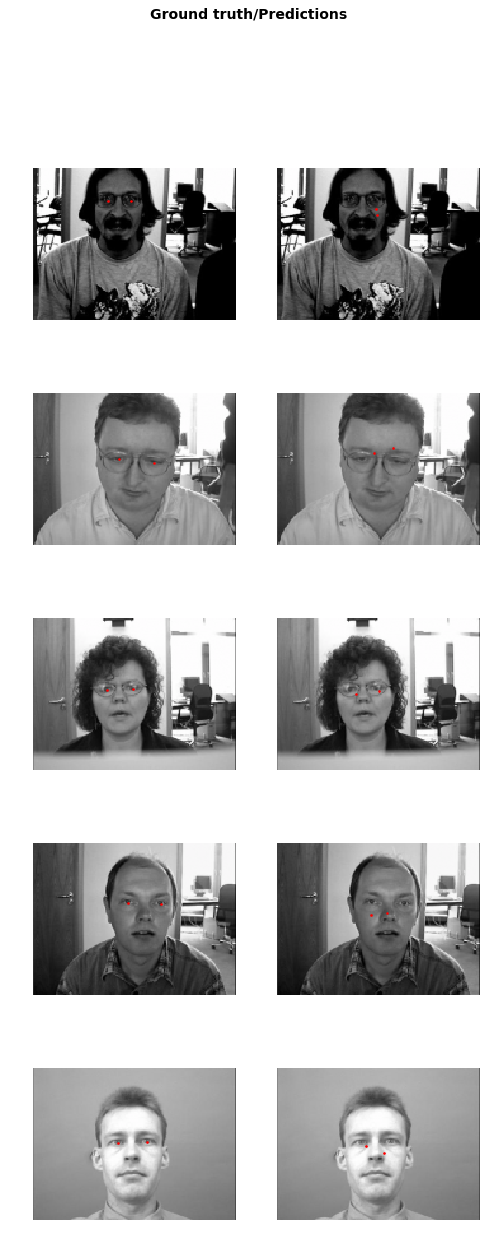

In [ ]:
learn2.show_results()

Train a lot more.

In [ ]:
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.016150,0.007016,00:13
1,0.012960,0.006823,00:13
2,0.010888,0.004232,00:13
3,0.008984,0.002156,00:13
4,0.007401,0.001431,00:13


And now the model is subjectively quite good.

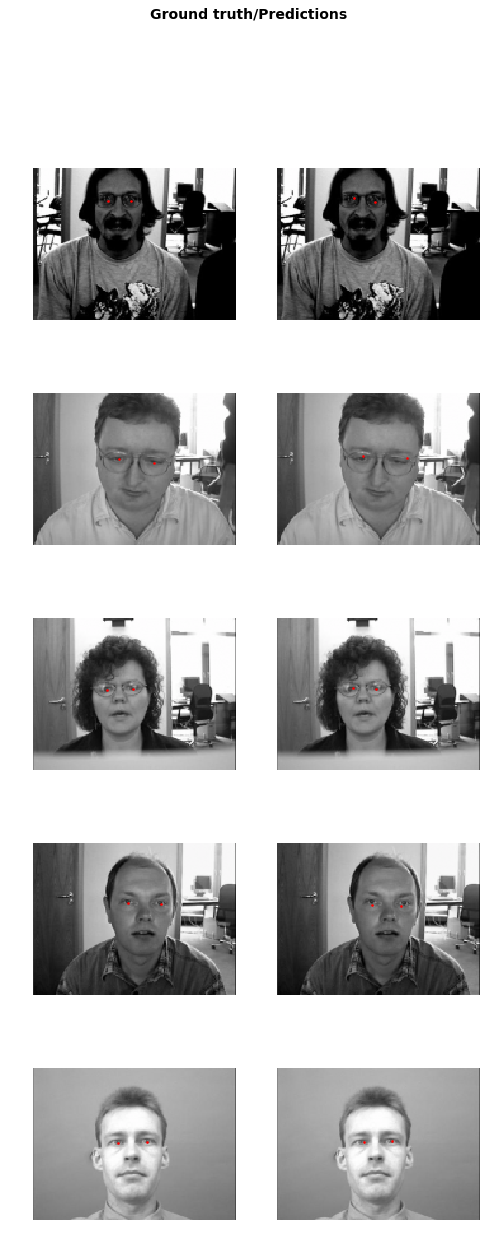

In [ ]:
learn2.show_results()

Save the model.

In [ ]:
learn2.save('/content/gdrive/My Drive/FaceDatabase/face2-stage2')

Train some more, but the improvement in training and validation loss is diminishing.

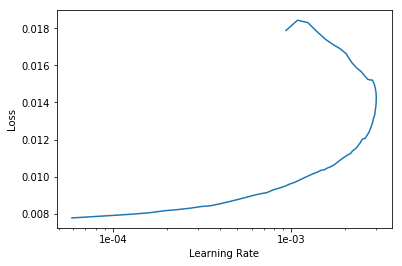

In [ ]:
learn2.recorder.plot()

In [ ]:
learn2.unfreeze()

In [ ]:
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.004910,0.003684,00:13
1,0.006395,0.007853,00:13
2,0.006716,0.002602,00:13
3,0.005777,0.001350,00:13
4,0.005048,0.000904,00:13


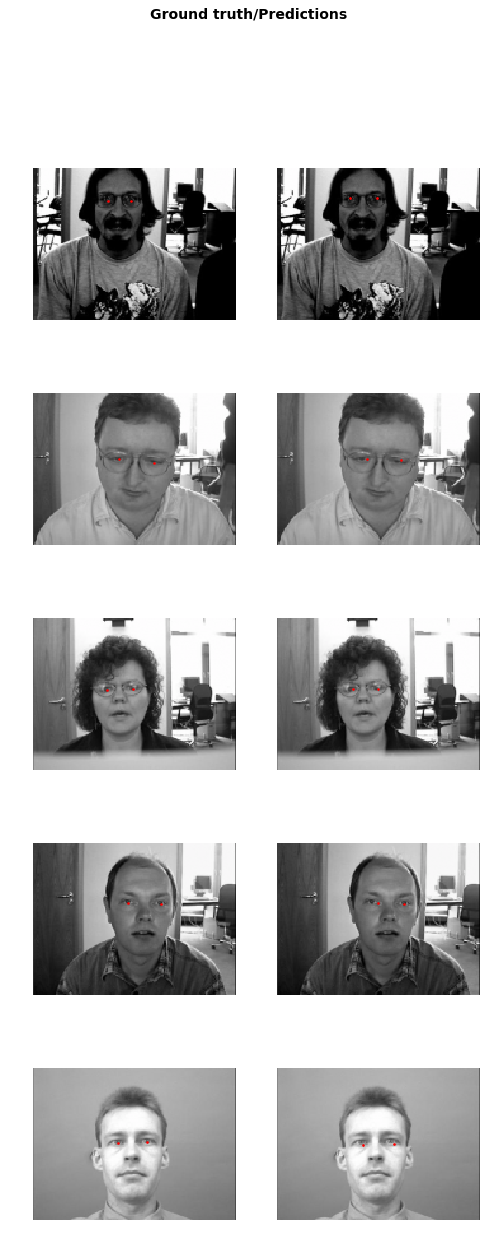

In [ ]:
learn2.show_results()

So let's stop there, and save the model.

In [ ]:
learn2.save('/content/gdrive/My Drive/FaceDatabase/face2-stage3')

---------------
## Conclusions

I was surprised at how easy it all was.  Of course, I am riding on the coat tails of the fastai team, and the people who marked up the eye-positions in the face database.

In a later blog post, I'll relate how well it went with a completely different database of faces (the Yale Face Database).  In summary, putting on dark glasses, or squinting / winking confuses my model, but for face-on normal images (face in repose) it does OK (subjectively).